## Modeling scATAC-seq using sequence features and a custom kNN graph

In this tutorial we demonstrate the applicability of mubind in a case where an arbitrarily complex graph is provided.
The dataset is mouse pancreatic endocrinogenesis multiome [Klein et al 2023]


In [74]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [75]:
import os
import seaborn

In [76]:
cd ~/workspace/theislab/mubind/docs/notebooks/single_cell

/home/ilibarra/workspace/theislab/mubind/docs/notebooks/single_cell


In [77]:
import pandas as pd
import numpy as np
import os
import torch
import itertools
import glob
import pandas as pd
from pathlib import Path
import bindome as bd
bd.constants.ANNOTATIONS_DIRECTORY = 'annotations'
import torch
import mubind as mb
from tqdm.notebook import tqdm_notebook as tqdm

In [78]:
# pwms = mb.datasets.cisbp_hs()
pwms = mb.datasets.archetypes()
# pwms = pwms[:20]
len(pwms)

# motifs loaded 2179


286

In [79]:
import random
# reduced_groups = [p.to_numpy() for p in random.sample(pwms, 20) if p.shape[-1] != 0]

In [80]:

# suppress numba deprecations warnings
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import warnings

warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)

In [81]:

import mubind as mb
import numpy as np
import pandas as pd
import torch
import bindome as bd
# mb.models.Mubind
import torch.optim as topti
import torch.utils.data as tdata
import matplotlib.pyplot as plt
import logomaker
import os
import scipy
import pickle

# Use a GPU if available, as it should be faster.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: " + str(device))

# device = 'cpu'

Using device: cuda:0


In [82]:
import scanpy as sc

In [83]:
# load the pancreas multiome dataset
rna, atac = mb.datasets.pancreas_multiome() # data_directory='../../../annotations/scatac')
rna.shape, atac.shape

True data/scatac/pancreas_multiome/pancreas_multiome_2022_processed_rna_velocities_2024.h5ad
True data/scatac/pancreas_multiome/pancreas_multiome_2022_processed_atac.h5ad


((16918, 14663), (16918, 228259))

In [84]:
# if rapids is available, use it
# import rapids_singlecell as rapids
# rapids.pp.neighbors(rna)

# if rapids is not avaible, default scanpy
sc.pp.neighbors(rna)


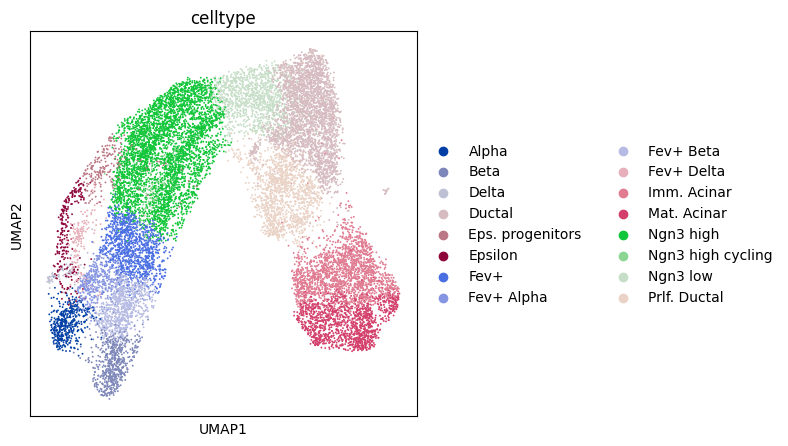

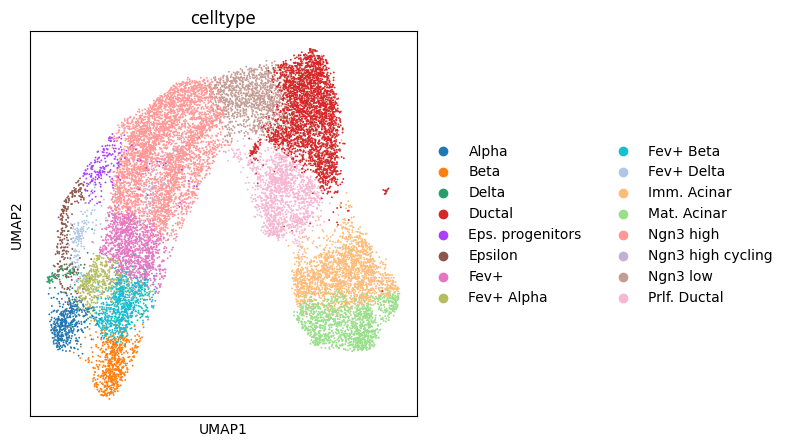

In [85]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 5, 5

# RNA
sc.pl.umap(rna, color='celltype')

#ATAC
sc.pl.umap(atac, color='celltype')

In [86]:
atac.obs_names

Index(['AAACAGCCAACAGCCT-1-0', 'AAACAGCCAACCCTCC-1-0', 'AAACAGCCACCTGTAA-1-0',
       'AAACAGCCACTAAGCC-1-0', 'AAACAGCCAGGATAAC-1-0', 'AAACAGCCATAAAGCA-1-0',
       'AAACATGCAAGGTAAC-1-0', 'AAACATGCAAGGTGGC-1-0', 'AAACATGCACTAGGTC-1-0',
       'AAACATGCAGCATTAT-1-0',
       ...
       'TTTGTGTTCACGAATC-1-1', 'TTTGTGTTCGAGCTAT-1-1', 'TTTGTGTTCGATCAGT-1-1',
       'TTTGTGTTCGCTATGG-1-1', 'TTTGTGTTCTCAATGA-1-1', 'TTTGTGTTCTTGTTCG-1-1',
       'TTTGTTGGTATTGAGT-1-1', 'TTTGTTGGTCCTAAGA-1-1', 'TTTGTTGGTTAACAGT-1-1',
       'TTTGTTGGTTGTTGCT-1-1'],
      dtype='object', length=16918)

In [87]:
# to match the barcode IDs, use the prefix from RNA to match ATAC (anchor = 10 first nucleotides)
assert np.all(rna.obs_names.str[:10] == atac.obs_names.str[:10])
rna.obs_names = atac.obs_names
rna.obs_names

Index(['AAACAGCCAACAGCCT-1-0', 'AAACAGCCAACCCTCC-1-0', 'AAACAGCCACCTGTAA-1-0',
       'AAACAGCCACTAAGCC-1-0', 'AAACAGCCAGGATAAC-1-0', 'AAACAGCCATAAAGCA-1-0',
       'AAACATGCAAGGTAAC-1-0', 'AAACATGCAAGGTGGC-1-0', 'AAACATGCACTAGGTC-1-0',
       'AAACATGCAGCATTAT-1-0',
       ...
       'TTTGTGTTCACGAATC-1-1', 'TTTGTGTTCGAGCTAT-1-1', 'TTTGTGTTCGATCAGT-1-1',
       'TTTGTGTTCGCTATGG-1-1', 'TTTGTGTTCTCAATGA-1-1', 'TTTGTGTTCTTGTTCG-1-1',
       'TTTGTTGGTATTGAGT-1-1', 'TTTGTTGGTCCTAAGA-1-1', 'TTTGTTGGTTAACAGT-1-1',
       'TTTGTTGGTTGTTGCT-1-1'],
      dtype='object', length=16918)

(array([  782.,   732.,   754.,   730.,   746.,   679.,   702.,   737.,
          666.,   657.,   638.,   621.,   587.,   636.,   639.,   640.,
          699.,   756.,   778.,   850.,   944.,  1070.,  1290.,  1566.,
         1888.,  2262.,  2990.,  3753.,  5173.,  6968., 10067., 15120.,
        26728., 62772., 71639.]),
 array([0.        , 0.01427051, 0.02854103, 0.04281154, 0.05708206,
        0.07135257, 0.08562309, 0.0998936 , 0.11416412, 0.12843463,
        0.14270515, 0.15697566, 0.17124618, 0.18551669, 0.19978721,
        0.21405772, 0.22832824, 0.24259875, 0.25686927, 0.27113978,
        0.2854103 , 0.29968081, 0.31395133, 0.32822184, 0.34249236,
        0.35676287, 0.37103339, 0.3853039 , 0.39957442, 0.41384493,
        0.42811545, 0.44238596, 0.45665648, 0.47092699, 0.48519751,
        0.49946802]),
 <BarContainer object of 35 artists>)

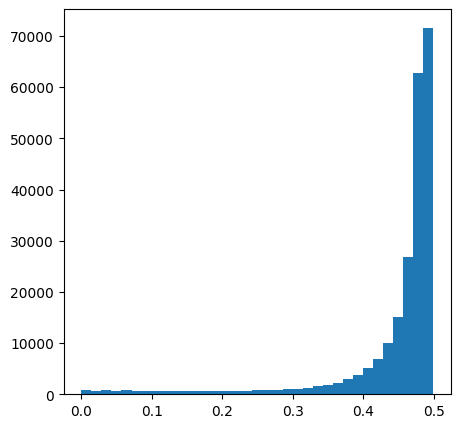

In [88]:
acc = (atac.X != 0).sum(axis=0) / atac.shape[0]
acc_score = abs(.5 - acc)
atac.var['acc_score'] = acc_score.A.T
atac.var['acc_score_rank'] = atac.var['acc_score'].rank(ascending=False)
plt.hist(atac.var['acc_score'], bins=35)
# var_sample = atac.var.sort_values('acc_score_rank').index[:n_sample_peaks]


In [89]:
atac.shape

(16918, 228259)

In [90]:
print('here...')

here...


In [91]:
n_select = atac.shape[0] # 500 # atac.shape[0] # 1500 # atac.shape[0] # 6000
n_sample_cells = n_select
# n_sample_peaks = 250
n_sample_peaks = int(n_sample_cells * .5) # atac.shape[1] # int(n_sample_cells * 1.5) # atac.shape[1] # int(n_sample_cells * 1.5)

n_cell_types = len(set(atac.obs['celltype']))

obs_sample = atac.obs.groupby('celltype').sample(int(n_sample_cells / n_cell_types), random_state=n_sample_cells, replace=True).index.drop_duplicates()
var_sample = pd.Series(atac.var_names).sample(n_sample_peaks, random_state=n_sample_peaks)
# var_sample = atac.var.sort_values('acc_score_rank').index[:n_sample_peaks]

ad = atac[atac.obs_names.isin(obs_sample),atac.var_names.isin(var_sample)].copy()
ad.shape

(8161, 8459)

In [92]:
ad.obs['celltype'].value_counts()

celltype
Ngn3 high            926
Ductal               864
Imm. Acinar          796
Prlf. Ductal         738
Mat. Acinar          723
Ngn3 low             699
Fev+                 692
Fev+ Beta            600
Beta                 474
Alpha                418
Fev+ Alpha           396
Epsilon              241
Eps. progenitors     202
Fev+ Delta           176
Ngn3 high cycling    139
Delta                 77
Name: count, dtype: int64

In [93]:

# ad.uns['velocity_graph'] = rna_sample.uns['velocity_graph']
# # ad.layers['velocity'] = rna_sample.layers['velocity']
# ad.uns['velocity_graph'].shape



In [94]:

rna_sample = rna[ad.obs_names]

mask = rna.obs_names.isin(rna_sample.obs_names)

# local one step transposition to finalize processing
vgraph = rna.uns['velocity_graph']
vgraph = vgraph[mask == 1]
vgraph = vgraph.T
vgraph = vgraph[mask == 1]
vgraph = vgraph.T
vgraph.shape

(8161, 8161)

In [95]:
# the scvelo package is a condition to explore the vector stream visualization. Not priority
import scvelo as scv

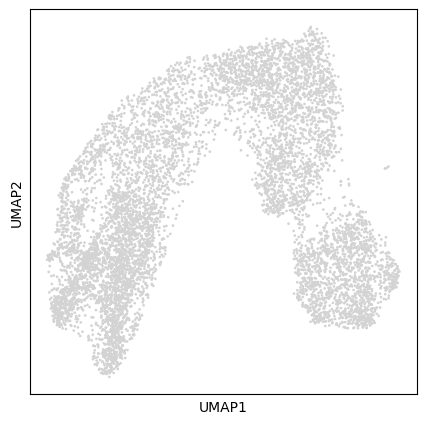

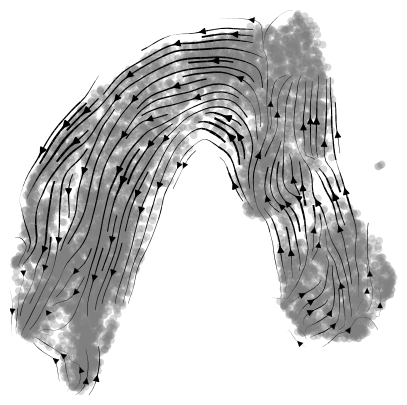

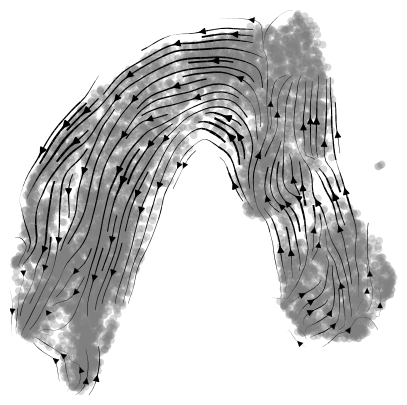

In [96]:

rna_sample.uns['velocity_graph'] = vgraph
try:
# atac
    sc.pl.umap(ad)

    # rna
    # append the estimated velocities to the sample adata
    scv.pl.velocity_embedding_stream(rna_sample)

    scv.pl.velocity_embedding_stream(rna_sample)
    rna_sample.shape
except Exception:
    print('sample too small to plot graph')


In [97]:
ad.var['chr'] = 'chr' + ad.var_names.str.split('-').str[0]
ad.var['start'] = ad.var_names.str.split('-').str[1].astype(int)
ad.var['end'] = ad.var_names.str.split('-').str[2].astype(int)

print('features by chromosome')
extend = 50
ad.var['chr'].value_counts()

features by chromosome


chr
chr2     686
chr1     605
chr11    553
chr5     523
chr4     509
chr6     489
chr7     485
chr3     471
chr10    464
chr9     458
chr8     421
chr12    397
chr13    370
chr15    362
chr14    345
chr17    322
chr18    298
chr16    266
chr19    252
chrX     182
chrY       1
Name: count, dtype: int64

In [98]:
ad.var['summit'] = ((ad.var['end'] + ad.var['start']) / 2).astype(int)
ad.var['summit.start'] = ad.var['summit'] - extend
ad.var['summit.end'] = ad.var['summit'] + extend
ad.var['k.summit'] = ad.var['chr'] + ':' + ad.var['summit.start'].astype(str) + '-' + ad.var['summit.end'].astype(str)

In [99]:
ad.shape

(8161, 8459)

In [100]:
n_seqs = ad.shape[1] # 10000 # adata.shape[1] # None # 1000
seqs = mb.bindome.tl.get_sequences_from_bed(ad.var[['chr', 'summit.start', 'summit.end']].head(n_seqs), genome='mm10', uppercase=True,
                                            gen_path='annotations/mm10/genome/mm10.fa',
                                            bin='/home/ilibarra/miniconda3/envs/mubind/bin/bedtools')
                                            # bin='/home/ilibarra/.conda/envs/mubind/bin/bedtools')
                                            # gen_path='../../../annotations/hg38/genome/hg38.fa')

keys = set([s[0] for s in seqs])
ad = ad[:,ad.var['k.summit'].isin(keys)]
# seqs = [[s[0], s[1].upper()] for s in seqs[0]]
len(seqs)

/tmp/tmpqlfmo0ty
genome mm10 True
annotations/mm10/genome/mm10.fa
True annotations/mm10/genome/mm10.fa
running bedtools...
['/home/ilibarra/miniconda3/envs/mubind/bin/bedtools', 'getfasta', '-fi', 'annotations/mm10/genome/mm10.fa', '-bed', '/tmp/tmpqlfmo0ty', '-fo', '/tmp/tmpttofrsjk']
/home/ilibarra/miniconda3/envs/mubind/bin/bedtools getfasta -fi annotations/mm10/genome/mm10.fa -bed /tmp/tmpqlfmo0ty -fo /tmp/tmpttofrsjk


8459

In [101]:
len(seqs)

8459

In [102]:
# remove Ns
for s in seqs:
    if 'N' in s:
        assert False
    # seqs = [[s[0], s[1].replace('N', '')] for s in seqs]
counts = ad.X.T

In [103]:
counts.shape

(8459, 8161)

In [104]:
next_data = pd.DataFrame(counts.A) # sparse.from_spmatrix(counts.A)

In [105]:
next_data['var'] = next_data.var(axis=1)
# next_data = next_data[range(100)].copy()

In [106]:
next_data.shape

(8459, 8162)

In [107]:
next_data.shape

(8459, 8162)

In [108]:
next_data.index = [s[1] for s in seqs]
next_data.index.name = 'seq'
next_data.shape

(8459, 8162)

In [109]:
next_data = next_data[~next_data.index.str.contains('N')]
next_data.shape

(8459, 8162)

In [110]:
# sum_index = next_data[next_data.columns[:-1]].var(axis=1).sort_values(ascending=False).index

In [111]:
next_data

,0,1,2,3,4,5,6,7,8,9,...,8152,8153,8154,8155,8156,8157,8158,8159,8160,var
seq,,,,,,,,,,,,,,,,,,,,,
ATGTAAACAGTGGAAATCAGGGACATAAAAGGAATGGTGATTGATAGTGTTTGTACCCAGCAGTTTGTCACTCTAGTTTATCCTCTGTCTGCATAGCAGT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.006698
GATACCACCAGATGCTTTATGTTTTGTTGGTTGTTTAGTAATTGGCTACAAGGAGAAACACACACGCACACGCACATGCACACGCACACACACACACGGG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.022447
AAGCCATTGAGTGGTCAAAGTTCAGTGAGCTTTTCTGGGGAGCTGGAAGGGTAAGAATGTTAGGATAAATGCAAATAATGGAGGCCTGGCTTTTGAAGTT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.015358
GCTGTGGGAGGAATTGGCACAGTTTCACATGACTGGTTCATTTAAACATCACCAAACTGTACGTGCAGATCGAGGTAACAGCAGAGCATCTGGTTAACAT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.020694
ACAGCCAATCAGGGAGTGATGCGTCCTAGGCGAAATATAACGCTCCTAAAAAAGGGGACGGGTTTCCGCCATTCTCTCTCGCTGGCATCTCTCTGGCTCT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.025182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TGTGCCGCCACACAGTGGCTTAGAGCTCAAGCTTAGGCTCTAGGTTTGGTATAACATTGAGCTGACACTATGTTGATATTCTTTAAAAAAAAACTGATAC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.020250
ATGGGAGCCAGACATAGGCAGTGACATGAAAATTGCTCTCTGCAAGGGCTGGCTCAATCCAGACAGAAAAGGTTCAAAGGTGAGTCAAAGGAATCAGGGG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.012399
TTAAAGGGAGTTGGGGGAGGAGCCCATCGGTATGTCTGCAATCTGTGTCACACAACACAGCAGAGAAATGTGAGAAATACCTGAGGAATTCCACATAAAT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.013701


In [112]:
# n_cells = next_data.shape[1] # 10000
# top_var = next_data[['var']].sort_values('var', ascending=False).index[:n_cells]

In [113]:
# next_data.index

In [114]:
# next_data = next_data.head(10000)
# next_data_sel = next_data.reindex(top_var) # .reset_index(drop=True)
next_data_sel = next_data
next_data_sel.shape

(8459, 8162)

In [115]:
del next_data_sel['var']
# next_data_sel.index = next_data_sel['seq']
# del next_data_sel['seq']

In [116]:
df = next_data_sel.copy() # sample
# df = df[df.columns[:5000]] # .head(100) # sample

# shorten sequences/remove duplicates
# df.index = df.index.astype(str).str[35:-35]
# df = df[~df.index.duplicated(keep='first')]

zero_counts = df.sum(axis=1) == 0
df = df[~zero_counts] # remove zeroes

df.shape

(8459, 8161)

In [117]:
ad.shape, df.shape

((8161, 8459), (8459, 8161))

In [118]:
ad.shape

(8161, 8459)

In [119]:
ad.shape

(8161, 8459)

In [120]:
# ad = ad[:,~zero_counts].copy()


In [121]:
print('here...')

here...


In [122]:
# df2 = df.reset_index().melt('seq').set_index('seq')
# # add a baseline count
# df2[0] = 1.0
# cols = ['batch', 1, 0]
# df2.columns = cols
# df2 = df2[[0, 1, 'batch']] # cols[::-1]]
# df2['batch'] = df2['batch'].astype(int)
# print(df2.shape)
# print(len(set(df2['batch'])))
# n_cells = 200
# df2 = df2[df2['batch'].isin(range(0, n_cells))]
# print(df2['batch'].value_counts())
# df2.head()

### Simple motif enrichment

In [123]:
use_kmers = False
if use_kmers:
    kmers_by_module = {}
    pwm_by_module = {}
    glossary_kmers_dir = '../../../../../zaugglab/apobec2_data_analysis/src/analyses_2023_new_sample/Glossary Modules'
    for f in os.listdir(glossary_kmers_dir):
        if not f.endswith('.xlsx'):
            continue
        name = f.replace('Glossary_module_', '').replace('.xlsx', '')
        kmers = pd.read_excel(os.path.join(glossary_kmers_dir, f), sheet_name='8mers')
        kmers_by_module[name] = kmers[kmers.columns[0]]
        pwm = pd.read_excel(os.path.join(glossary_kmers_dir, f), sheet_name='PWM', index_col=0)
        pwm_by_module[name] = pwm

### Generate pos and neg

In [124]:
# import ushuffle

# fg = df.index
# bg = []

# for i, s in enumerate(fg):
#     # print(i, s)
#     bg.append(ushuffle.shuffle(str.encode(s), 2))



In [125]:
# for a, b in zip(fg, bg):
#     # print(len(a[1]), len(b))
#     assert len(a) == len(b)

In [126]:
frac_acc = (df > 0).sum(axis=0) / df.shape[1]

In [127]:
reduced_groups = pwms

In [128]:
# save for probound
# df.to_csv('probound_input_pancreatic_scatac.csv.gz')

In [129]:
dataset = mb.datasets.SelexDataset(df, n_rounds=df.shape[1], enr_series=False)
n_batch = len(set(dataset.batch))
n_kernels = len(pwms)
train = tdata.DataLoader(dataset=dataset, batch_size=128, shuffle=True)


In [130]:
# df_neg = df.copy()
# df_neg.index = bg
# df_neg.index = df_neg.index.astype(str)

# dataset_neg = mb.datasets.SelexDataset(df_neg, n_rounds=df_neg.shape[1], enr_series=False)
# train_neg = tdata.DataLoader(dataset=dataset_neg, batch_size=512, shuffle=True)


### The parameter log_dynamic defines whether a kNN-graph will be used

In [131]:
len(pwms)

286

In [132]:
# for unit tests
# torch.save(train, '../../../tests/_data/pancreas_multiome.pth')
# ad.write('../../../tests/_data/pancreas_multiome.h5ad', compression='lzf')

In [133]:
rna_sample.shape, ad.shape

((8161, 14663), (8161, 8459))

In [134]:
criterion = mb.tl.PoissonLoss()
w = [r.shape[1] for r in pwms]
optimize_log_dynamic = True
model = mb.models.Mubind.make_model(train, n_kernels, criterion, kernels=[0, 2,] + w, # [0, 2] + w,
                                        # use_dinuc=True, dinuc_mode='full',
                                        optimize_sym_weight=False,
                                        optimize_exp_barrier=True,
                                        optimize_prob_act=True,
                                        optimize_log_dynamic=optimize_log_dynamic,
                                        use_dinuc=False,
                                        device=device,
                                        p_dropout=0.8,
                                        prepare_knn=optimize_log_dynamic,
                                        velocity_graph=vgraph,
                                        knn_free_weights=False,
                                        adata=None if not optimize_log_dynamic else ad,
                                        dinuc_mode=None)
print('no err')

(8161, 8161)
setting up log dynamic
no err


In [135]:
for i, batch in enumerate(train):
    # print(i, 'batches out of', n_batches)
    # Get a batch and potentially send it to GPU memory.
    mononuc = batch["mononuc"] # .to(self.device)
    print(mononuc.shape)

torch.Size([128, 4, 100])
torch.Size([128, 4, 100])
torch.Size([128, 4, 100])
torch.Size([128, 4, 100])
torch.Size([128, 4, 100])
torch.Size([128, 4, 100])
torch.Size([128, 4, 100])
torch.Size([128, 4, 100])
torch.Size([128, 4, 100])
torch.Size([128, 4, 100])
torch.Size([128, 4, 100])
torch.Size([128, 4, 100])
torch.Size([128, 4, 100])
torch.Size([128, 4, 100])
torch.Size([128, 4, 100])
torch.Size([128, 4, 100])
torch.Size([128, 4, 100])
torch.Size([128, 4, 100])
torch.Size([128, 4, 100])
torch.Size([128, 4, 100])
torch.Size([128, 4, 100])
torch.Size([128, 4, 100])
torch.Size([128, 4, 100])
torch.Size([128, 4, 100])
torch.Size([128, 4, 100])
torch.Size([128, 4, 100])
torch.Size([128, 4, 100])
torch.Size([128, 4, 100])
torch.Size([128, 4, 100])
torch.Size([128, 4, 100])
torch.Size([128, 4, 100])
torch.Size([128, 4, 100])
torch.Size([128, 4, 100])
torch.Size([128, 4, 100])
torch.Size([128, 4, 100])
torch.Size([128, 4, 100])
torch.Size([128, 4, 100])
torch.Size([128, 4, 100])
torch.Size([

[autoreload of mubind.models.models failed: Traceback (most recent call last):
  File "/home/ilibarra/miniconda3/envs/mubind/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/home/ilibarra/miniconda3/envs/mubind/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 475, in superreload
    module = reload(module)
  File "/home/ilibarra/miniconda3/envs/mubind/lib/python3.9/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 613, in _exec
  File "<frozen importlib._bootstrap_external>", line 846, in exec_module
  File "<frozen importlib._bootstrap_external>", line 983, in get_code
  File "<frozen importlib._bootstrap_external>", line 913, in source_to_code
  File "<frozen importlib._bootstrap>", line 228, in _call_with_frames_removed
  File "/home/ilibarra/workspace/theislab/mubind/mubind/models/models.py", line 1581
  

setting up log dynamic
order None
0 out of 288...
break


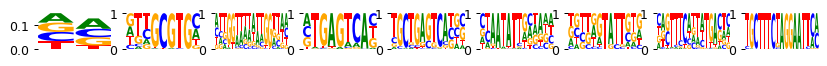

verbose=2
current kernel 0

### next filter to optimize 0 (intercept)

FREEZING KERNELS
optimizing feature type mono
next kernels 0-69, n=70
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 4
lr= 0.01, weight_decay= 0, dir weight= 0


  0%|                                                                                                                                                                                                         | 0/15 [00:00<?, ?it/s]

here torch.Size([128, 4, 146]) torch.Size([128, 4, 146])
1 Conv1d(4, 1, kernel_size=(2,), stride=(1,), bias=False)
here torch.Size([128, 4, 146]) torch.Size([128, 4, 146])
2 Conv1d(4, 1, kernel_size=(9,), stride=(1,), bias=False)
here torch.Size([128, 4, 146]) torch.Size([128, 4, 146])
3 Conv1d(4, 1, kernel_size=(18,), stride=(1,), bias=False)
here torch.Size([128, 4, 146]) torch.Size([128, 4, 146])
4 Conv1d(4, 1, kernel_size=(9,), stride=(1,), bias=False)
here torch.Size([128, 4, 146]) torch.Size([128, 4, 146])
5 Conv1d(4, 1, kernel_size=(13,), stride=(1,), bias=False)
here torch.Size([128, 4, 146]) torch.Size([128, 4, 146])
6 Conv1d(4, 1, kernel_size=(14,), stride=(1,), bias=False)
here torch.Size([128, 4, 146]) torch.Size([128, 4, 146])
7 Conv1d(4, 1, kernel_size=(13,), stride=(1,), bias=False)
here torch.Size([128, 4, 146]) torch.Size([128, 4, 146])
8 Conv1d(4, 1, kernel_size=(17,), stride=(1,), bias=False)
here torch.Size([128, 4, 146]) torch.Size([128, 4, 146])
9 Conv1d(4, 1, ker

  0%|                                                                                                                                                                                                         | 0/15 [00:08<?, ?it/s]


KeyboardInterrupt: 

In [138]:
import torch.optim as topti
import warnings

model_by_logdynamic = {}
n_epochs_intercept = 15
n_epochs_kernel = 15
log_each=75
n_unfreeze_kernels=70


for optimize_log_dynamic in [True, False]:
    warnings.filterwarnings("ignore")

    criterion = mb.tl.PoissonLoss()
    w = [r.shape[1] for r in pwms]
    model = mb.models.Mubind.make_model(train, n_kernels, criterion, kernels=[0, 2,] + w, # [0, 2] + w,
                                           # use_dinuc=True, dinuc_mode='full',
                                           optimize_sym_weight=False,
                                           optimize_exp_barrier=True,
                                           optimize_prob_act=True,
                                           optimize_log_dynamic=optimize_log_dynamic,
                                           use_dinuc=False,
                                           device=device,
                                           p_dropout=0.8,
                                           prepare_knn=optimize_log_dynamic,
                                           knn_free_weights=False,
                                           adata=None if not optimize_log_dynamic else ad,
                                           dinuc_mode=None) # .cuda()

    # initialize the reduce kernels
    for i, mono_best in enumerate(pwms):
        mono_best = mono_best.to_numpy()
        if mono_best.shape[-1] == 0:
            continue
        # print(mono_best.shape, model.binding_modes.conv_mono[i + 1].weight.shape)
        # print(model.binding_modes.conv_mono[i + 1].weight.device)
        new_w = mono_best.reshape([1, 1] + list(mono_best.shape))
        # print(i, i + 1)
        # assert False
        model.binding_modes.conv_mono[i + 2].weight = torch.nn.Parameter(torch.tensor(new_w, dtype=torch.float).squeeze(1))
        # print(model.binding_modes.conv_mono[i + 1].weight.device)
    # move the model a final time to the GPU
    model = model.to(device)

    mb.pl.set_rcParams({'figure.figsize': [15, 3], 'figure.dpi': 90})
    mb.pl.logo(model,
               title=False,
               xticks=False,
               rowspan_dinuc=0,
               rowspan_mono=1,
               n_rows=5,
               n_cols=12,
               stop_at=10   ) # n_cols=len(reduced_groups))

    mb.pl.set_rcParams({'figure.figsize': [20, 5], 'figure.dpi': 100})

    # mb.pl.conv(model, n_cols=2)
    import torch.nn as tnn

    model.graph_module.use_hadamard = True
    model, best_loss = model.optimize_iterative(train,
                                                n_epochs=[n_epochs_intercept] + [n_epochs_kernel] * (n_kernels + 1),
                                                show_logo=False,
                                                use_mono=True, use_dinuc=False, dinuc_mode='local',
                                                opt_kernel_shift=[0, 0] + [0] * (n_kernels),
                                                opt_kernel_length=[0, 0] + [0] * (n_kernels),
                                                opt_one_step=True,
                                                shift_max=1, shift_step=1,
                                                # optimiser=topti.SGD,
                                                optimiser=topti.Adam,
                                                rel_chg_early_stop=5e-3,
                                                n_unfreeze_kernels=n_unfreeze_kernels,
                                                # skip_kernels=list(range(1, 2)) + list(range(5, 500)),
                                                n_batches=1, n_rounds=2, num_epochs_shift_factor=1, # log_etas=log_etas, # log_etas=log_etas,
                                                kernels = [0] + [2] + [20] * (n_kernels), r2_per_epoch=True,
                                                exp_max=8,
                                                early_stopping=4, log_each=log_each, w=20, max_w=20) #  target_dim=train.dataset.signal.shape[1])

    model_by_logdynamic[optimize_log_dynamic] = model

Text(0.5, 0, 'learned etas (per sample)')

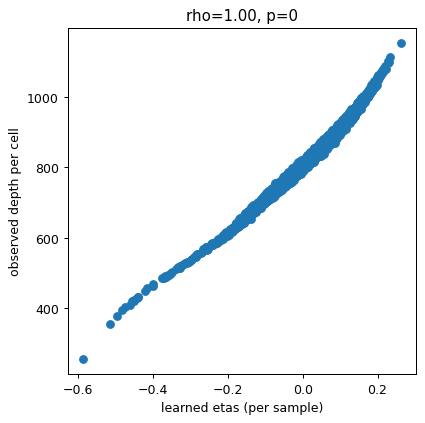

In [ ]:
## correlation between etas and observed counts per cell
rcParams['figure.figsize'] = 5, 5
etas = model.get_log_etas()
lib_sizes = train.dataset.rounds.sum(axis=0)
etas.shape, lib_sizes.shape
from scipy.stats import spearmanr

a = etas.detach().cpu().flatten()
b = lib_sizes.flatten()
plt.scatter(a, b)
plt.title('rho=%.2f, p=%.2g' % spearmanr(a, b))
plt.ylabel('observed depth per cell')
plt.xlabel('learned etas (per sample)')

In [ ]:
save_output = True

if save_output:
    for use_logdynamic in [False, True]:
        p = 'pancreas_multiome_use_logdynamic_%i_obs%i_var%i.pth' % (use_logdynamic, ad.shape[0], ad.shape[1])
        print(p)
        torch.save(model_by_logdynamic[use_logdynamic], p)

    ad.write('atac_train.h5ad')
    rna_sample.write('rna_sample_train.h5ad')

    import pickle
    pickle.dump(train, open('train_dataloader.pkl', 'wb'))

pancreas_multiome_use_logdynamic_0_obs8161_var50000.pth
pancreas_multiome_use_logdynamic_1_obs8161_var50000.pth


In [ ]:
ls -lhtr pancreas*

-rwxrwxr-x 1 ilibarra ilibarra 1.8M Jun 10 10:55 pancreas_multiome_use_logdynamic_0.pth*
-rwxrwxr-x 1 ilibarra ilibarra 1.8M Jun 10 10:55 pancreas_multiome_use_logdynamic_1.pth*
-rw-rw-r-- 1 ilibarra ilibarra 2.7M Jun 11 00:19 pancreas_multiome_use_logdynamic_0_obs912.pth
-rw-rw-r-- 1 ilibarra ilibarra 2.8M Jun 11 00:19 pancreas_multiome_use_logdynamic_1_obs912.pth
-rw-rw-r-- 1 ilibarra ilibarra 9.8M Jun 11 20:19 pancreas_multiome_use_logdynamic_0_obs4148.pth
-rw-rw-r-- 1 ilibarra ilibarra  11M Jun 11 20:19 pancreas_multiome_use_logdynamic_1_obs4148.pth
-rw-rw-r-- 1 ilibarra ilibarra 1.6M Jul  7 21:53 pancreas_multiome_use_logdynamic_1_obs480.pth
-rw-rw-r-- 1 ilibarra ilibarra 3.5M Jul  7 22:02 pancreas_multiome_use_logdynamic_1_obs1300.pth
-rw-rw-r-- 1 ilibarra ilibarra  843 Jul  7 22:59 pancreas_multiome_use_logdynamic_0_obs1300.pth
-rw-rw-r-- 1 ilibarra ilibarra  837 Jul  8 00:30 pancreas_multiome_use_logdynamic_0_obs96.pth
-rw-rw-r-- 1 ilibarra ilibarra  840 Jul  8 00:32 pancreas_m